# Character-Level Bigram Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

This is based on [this tutorial](https://www.youtube.com/watch?v=PaCmpygFfXo) by [Andrej Karpathy](https://karpathy.ai/) on language modeling. In this tutorial, we use a dataset of names to train a bigram character-level language model. This model can be used to generate new names using a Markov process. The focus is on introducing the overall framework of language modeling that includes probabilistic modeling, model training, sampling, and the evaluation of models using a loss function (e.g. the negative log likelihood for classification). 

Probabilities of bigrams will be modeled by (1) counting and (2) using a simple neural network with a single hidden layer. Models developed here will, in further tutorials, complexify into a modern [Transformer](https://arxiv.org/abs/1706.03762) language model (such as [GPT](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)). 

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

## Names dataset

First, we get the dataset of names that we will model:

In [2]:
words = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
print(len(words))
words[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

A name is simply a sequence of characters. Language modeling is assigning probabilities to a sequence of characters. Our dataset which consists of over 32,000 names has a lot of structure both local (character-level) and global (name-level). 

Note that our names are not infinite sequences &mdash; it has a start and an end. So we have to have tokens for these delimiters. Moreover, most names have zero probability of occuring, i.e. names with the end token before the start token. We will develop a weak model which essentially models [Markov process](https://en.wikipedia.org/wiki/Markov_chain) of length 1. To model this, we have use **bigrams**. Bigrams of the first name are: 

In [3]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        print(c1, c2)

<S> e
e m
m m
m a
a <E>


Getting all bigrams:

In [4]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        bigram = (c1, c2)
        b[bigram] = b.get(bigram, 0) + 1

The following bigrams occur most frequently. For instance, `a` occurs as the first letter in 4410 names. And most names end with `n` and `a`. 

In [5]:
sorted(b.items(), key=lambda kv: -kv[1])[:20]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422)]

## Counting bigrams

To structure the data better, we will store this in a 2D array. An entry `[i, j]` in this array is the count of bigrams that start with the `i`th character followed by the `j`th character. Also, we incorporate the following fact that a single delimiter suffices. That is, we can use a `.` to signify the start of a name which will be closed by another `.` to signify the end of a name. Iterating over the names to get all bigrams:

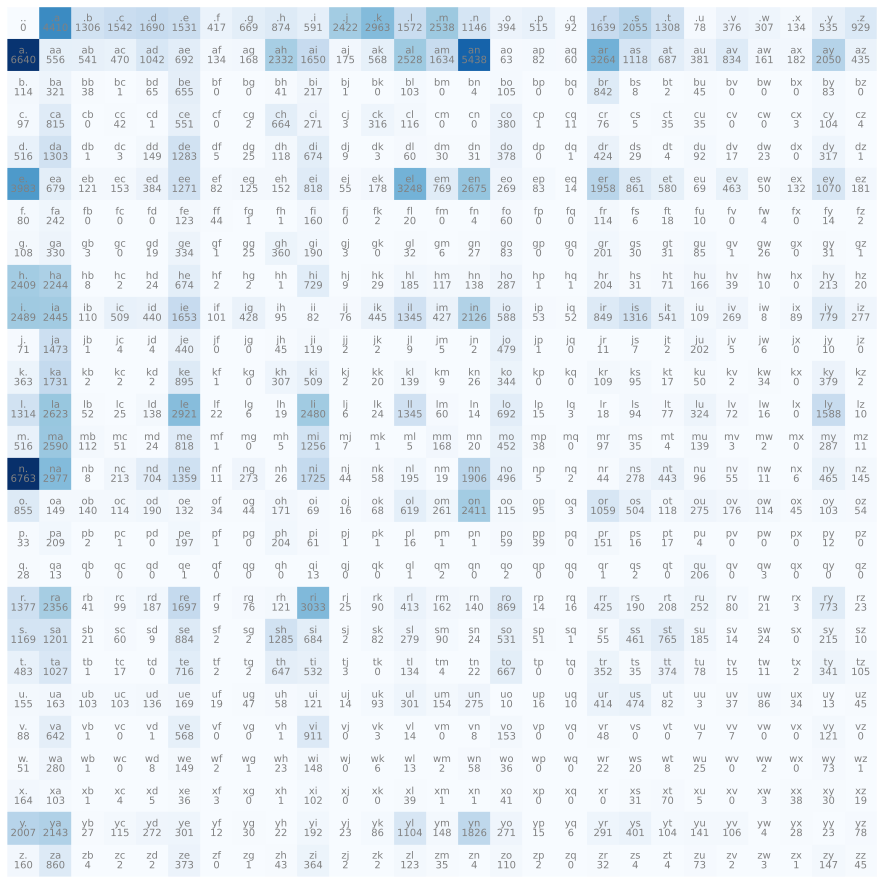

In [6]:
import torch

# Create count matrix
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(chars)}
n = len(chars)
N = torch.zeros((n, n), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        N[stoi[c1], stoi[c2]] += 1

# Visualize count matrix
itos = {i: s for s, i in stoi.items()}
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')

plt.axis('off');

### Generating names

Already at this point we can generate names. Recall that to model joint distributions, we can use a [chain of probabilities](https://d2l.ai/chapter_recurrent-neural-networks/sequence.html#markov-models). But conditioning only on the last character as a form of truncation. Given a discrete joint probability `P`, we sample the first character of a name from a marginal distribution and go from there sampling each character conditioned purely on the previous sampled character. This conditional distribution corresponds to `P[ix, :] / P[ix, :].sum()` where `ix` is the index of the previous character. 

In [7]:
def generate_names(P, n, seed=2147483647):
    """Generate names from a Markov process with joint probability P."""

    g = torch.Generator().manual_seed(seed)
    P /= P.sum(dim=1, keepdim=True)
    names = []
    for _ in range(n):
        ix = 0
        out = []
        while True:
            p = P[ix]
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            out.append(itos[ix])
            if ix == 0:
                break    
        names.append(''.join(out[:-1]))
    return names

Generate names from the joint distribution estimated by counting:

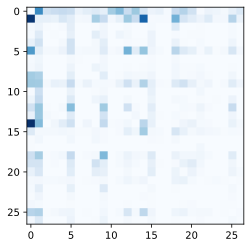

In [8]:
P = N.float() / N.sum()
plt.imshow(P, cmap='Blues');

In [9]:
generate_names(P, 10)

['mor',
 'axx',
 'minaymoryles',
 'kondlaisah',
 'anchshizarie',
 'odaren',
 'iaddash',
 'h',
 'jhinatien',
 'egushl']

Note that modeling using bigrams is pretty bad. But it still looks better than random. One reason this is bad is that the next most probable bigram has probability that drops exponentially from the last. This is known as [Zipf's law](https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html#exploratory-language-statistics). Interestingly, this holds even for trigrams, and so on, and even for word-level language modeling.

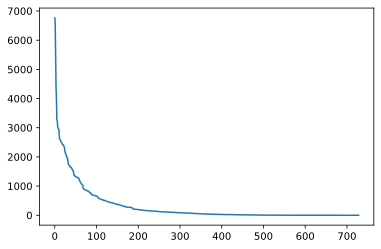

In [10]:
plt.plot(sorted(N.reshape(-1), reverse=True));

### Model quality: MLE = NLL loss

The **likelihood** of a dataset is the probability assigned by the model on that dataset. This can be expressed as a product of likelihood of data points. Since a product of many small positive numbers quickly vanishes to zero, we typically take the logarithm which converts this product into a sum. Hence, we take the **log-likelihood** for describing a model.

[Maximum likelihood estimation](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#the-maximum-likelihood-principle) (MLE) means choosing the model parameters (e.g. assignment of probabilities) such that the likelihood of the dataset is maximized. Since we typically want to minimize a positive function, MLE is equivalent to minimizing the **negative log-likelihood** (NLL). Hence, we take the NLL as the loss function for the model. Note that we take the mean to normalize the loss value over the size of the dataset.

In [11]:
class BigramModel:
    def __init__(self):
        """
        Sequence model that uses bigrams / Markov process 
        for estimating probability of next char: P(b | a).
        """
        self.P = None

    def __call__(self, x: int) -> list[float]:
        return torch.tensor([self.P[x, y] for y in range(27)])

    def fit(self, xs, ys):
        N = torch.zeros((27, 27), dtype=torch.int32)
        for x, y in zip(xs, ys):
            N[x, y] += 1

        self.P = N / N.sum()
        self.P /= self.P.sum(dim=1, keepdim=True)


# Input / target sequences
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        xs.append(stoi[c1])
        ys.append(stoi[c2])

# Fitting the bigram model
bigram_model = BigramModel()
bigram_model.fit(xs, ys)

Compute NLL of bigram model:

In [12]:
log_likelihood = 0.0
n = 0
for x, y in zip(xs, ys):
    p = bigram_model(x)[y]
    log_p = torch.log(p)
    log_likelihood += log_p
    n += 1
    if n < 12:
        print(f'{itos[y]}    {itos[x]}{itos[y]}    p={p:.4f}    nll={-log_p:.4f}')

nll = -log_likelihood
print(f"nll = {nll / n:.4f} (overall)")

e    .e    p=0.0478    nll=3.0408
m    em    p=0.0377    nll=3.2793
m    mm    p=0.0253    nll=3.6772
a    ma    p=0.3899    nll=0.9418
.    a.    p=0.1960    nll=1.6299
o    .o    p=0.0123    nll=4.3982
l    ol    p=0.0780    nll=2.5508
i    li    p=0.1777    nll=1.7278
v    iv    p=0.0152    nll=4.1867
i    vi    p=0.3541    nll=1.0383
a    ia    p=0.1381    nll=1.9796
nll = 2.4541 (overall)


Observe that a model that assigns a probability of `1.0` for each next actual character has an NLL of exactly `0.0`. Here our bigram model gets penalized for next characters whose bigrams from the previous character occurs rarely on the training dataset.

### Smoothing

Note that the penalty can even result in `+inf` loss when this encounters a bigram with zero counts in the training data, e.g. the name `gopde` since the bigram `pd` never appears on the training data. One way to fix this is to perform **model smoothing**. This can be done by adding a fixed constant to the counts:

```python
a = 2
P = (N + a).float() / (N + a).sum()
```

The larger the constant `a`, the more uniform the resulting probabilities are. Hence, the term smoothing. 

## Modeling probabilities with a neural network

We will still model names using bigrams, but the assignment of conditonal probabilities is estimated by initializing random weights which is fine-tuned using gradient descent. Again we want to maximize the probabilities of the actual next characters so that the likelihood of the training dataset is maximized. Constructing our sequence data:

In [13]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

Since neural nets can only handle numbers, our input data are encoded as integers. But how do we plug this into a neural net? An easy way to do this is to use one-hot vectors. Note that we convert to float since we want to push these into a neural net with float weights. This can be done using `.float()` since `F.one_hot` does not take in a `dtype` argument. The alternative is to use a single unit as input neuron, but this doesn't seem like a good idea.

tensor([ 0,  5, 13, 13,  1])


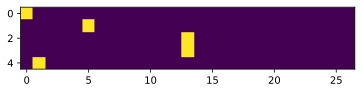

In [14]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
print(xs[:5])
plt.imshow(xenc[:5, :]); # 0, 5, 13, 13, 1, ...

In [15]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

(xenc @ W).shape

torch.Size([228146, 27])

The design of our neural net is to have a single hidden layer with weights `W` of size  `(27, 27)`. The entries of `W` correspond to the same joint probability distribution as above (or to the count matrix). In particular, each row of the matrix `W` correspond to a probability distribution of the next character. This conditional distribution is picked out via matrix multiplication with the one-hot encoding of the index.

In [16]:
class NNModel:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ self.W                         # init -> log-counts
        counts = logits.exp()                          # nonlinearity -> counts
        probs = counts / counts.sum(1, keepdims=True)  # softmax -> probability
        return probs
        
    def zero_grad(self):
        self.W.grad = None

    def optim_step(self, lr):
        self.W.data -= lr * self.W.grad


```{figure} ../../img/bigram-nn.drawio.svg
---
width: 450px
name: bigram-nn.drawio
---

Each entry of the weights $\boldsymbol{\mathsf W}$ is interpreted as **log-counts** (perhaps with scaled counts) with values in $(-\infty, \infty)$. This is then exponentiated to get to units of count with values in $(0, \infty).$ Note that the probabilities are obtained by normalizing the counts. In principle, this is simply an application of $\mathsf{softmax}$ on a square matrix to get a probability distribution over the input space. Observe that backpropagating on this network correspond to learning the bigram distributions given a previous character $a.$
```

Outputs of the hidden layer are interpreted as log-counts:

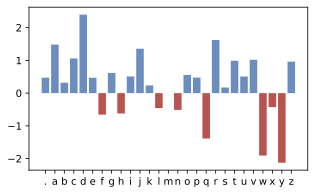

In [17]:
log_counts = (xenc[1] @ W).detach().numpy()
plt.figure(figsize=(5, 3))
plt.bar(stoi.keys(), log_counts, color=['#B85450' if y < 0 else '#6C8EBF' for y in log_counts]);

Exponentiating these correspond to counts. Normalizing this gives us a probability distribution:

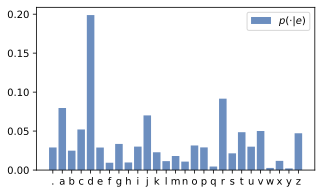

In [18]:
counts = (xenc[1] @ W).exp().detach().numpy()
counts /= counts.sum()
plt.figure(figsize=(5, 3))
plt.bar(stoi.keys(), counts, color=['#6C8EBF' for y in counts], label=f"$p( \cdot | {itos[xs[1].item()]})$")
plt.legend();

### Model training

Training the above network by minimizing its expected NLL on next actual characters:

In [19]:
model = NNModel(seed=12)

losses = []
num_steps = 100
for k in range(num_steps):
    probs = model(xs)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()  # nll

    model.zero_grad()
    loss.backward()
    model.optim_step(lr=50.0)
    
    # logging
    losses.append(loss.item())
    if k % 10 == 9:
        print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

[010/100]   loss=2.6704
[020/100]   loss=2.5613
[030/100]   loss=2.5241
[040/100]   loss=2.5052
[050/100]   loss=2.4939
[060/100]   loss=2.4865
[070/100]   loss=2.4814
[080/100]   loss=2.4776
[090/100]   loss=2.4747
[100/100]   loss=2.4724


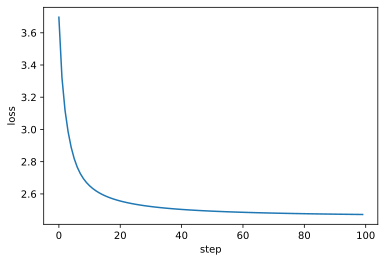

In [20]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('step');

For more complex neural nets, the only thing that will change is how to compute and assign probabilities to the next character. For example, we can use trigrams. Although, this is already looking like a not scalable approach. Another thing we can try is to have more complex neural network architecture for computing character dependencies.

### Sampling

In [21]:
counts = model.W.exp()
probs = counts / counts.sum() 
[print(n) for n in generate_names(probs, n=10)];

mor
axwaninaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jionatien
egxver
ga


It looks like we recovered the original count matrix (or similar)!

### Regularization

Observe that smoothing the count matrix approximates to it having constant entries. In the context of the neural net model, this means having a zero weight matrix so that the resulting count matrix `W.exp()` is a matrix of ones.

So the more getting zero weights is incentivized in the loss function, the more uniform the resulting distribution is. This is precisely weight **regularization**. For example, we can add $\frac{\alpha}{n}\lVert \boldsymbol{\mathsf W} \rVert^2_2$ where $n = |\boldsymbol{\mathsf W}|$ to the loss function:

```python
loss += 0.1 * model.W.square().mean()
```

Regularization acts sort of like a force that pushes the weights to zero whenever its magnitude increases (e.g. to try to reduce the NLL loss).

## Appendix: Exercises

### Exercise 1

Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss. Did it improve over a bigram model?



**Solution.** A neural net model seems more straightforward to implement.

In [22]:
from itertools import product

chars = [x + y for x, y in product(stoi.keys(), stoi.keys())]
stoi2 = {s: i for i, s in enumerate(chars)}
itos2 = {i: s for s, i in stoi2.items()}

# Input / target sequences. 
# Saving a group index for GroupKFold in E02.
xs, ys = [], []
groups = []
for i, w in enumerate(words):
    chs = ['.'] + list(w) + ['.']
    for c1, c2, c3 in zip(chs[:-2], chs[1:-1], chs[2:]):
        xs.append(stoi2[c1 + c2])
        ys.append(stoi[c3])
        groups.append(i)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

Trigram model just has more input neurons in its hidden layer:

In [23]:
class TrigramModel:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27*27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        xenc = F.one_hot(xs, num_classes=27*27).float()
        logits = xenc @ self.W                         # init -> log-counts
        counts = logits.exp()                          # nonlinearity -> counts
        probs = counts / counts.sum(1, keepdims=True)  # softmax -> probability
        return probs
        
    def zero_grad(self):
        self.W.grad = None

    def optim_step(self, lr):
        self.W.data -= lr * self.W.grad

Training:

In [24]:
def train_model(model, xs, ys, num_steps=100, lr=50.0):
    for k in range(num_steps):
        probs = model(xs)
        loss = -probs[torch.arange(len(ys)), ys].log().mean()

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses.append(loss.item())
        if k % 10 == 9:
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

    return losses


model = TrigramModel()
train_model(model, xs, ys);

[010/100]   loss=3.2073
[020/100]   loss=2.9296
[030/100]   loss=2.7705
[040/100]   loss=2.6678
[050/100]   loss=2.5948
[060/100]   loss=2.5393
[070/100]   loss=2.4950
[080/100]   loss=2.4587
[090/100]   loss=2.4283
[100/100]   loss=2.4025


It improved! (Previous best is `nll=2.4541`).

### Exercise 2

Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

**Solution.** Splitting using [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) so that bigrams coming from same names are placed in the same fold.

In [25]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=10)
folds = torch.zeros_like(xs)
for fold, (trn_, val_) in enumerate(gkf.split(xs.numpy(), ys.numpy(), groups)):
    folds[val_] = fold

xs_trn, ys_trn = xs[folds >  1], ys[folds >  1]
xs_dev, ys_dev = xs[folds == 1], ys[folds == 1]
xs_tst, ys_tst = xs[folds == 0], ys[folds == 0]

Modifying our training function to include validation:

In [26]:
def nll_loss(model, xs, ys):
    probs = model(xs)
    n = len(ys)
    return -probs[torch.arange(n), ys].log().mean()

def train_model(
        model, 
        xs, ys, 
        xs_dev, ys_dev, 
        xs_tst, ys_tst,
        num_steps=100, 
        lr=50.0,
        loss_fn=nll_loss,
        verbose=True
    ):
    
    losses_trn = []
    losses_dev = []
    for k in range(num_steps):
        loss = loss_fn(model, xs, ys)

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses_trn.append((k, loss.item()))
        if k % 10 == 9:
            dev_loss = loss_fn(model, xs_dev, ys_dev)
            losses_dev.append((k, dev_loss.item()))
            if verbose:
                print(f"[{k+1:>03d}/{num_steps}]    loss={loss:.4f}    dev_loss={dev_loss:.4f}")
    
    if verbose:
        print(f'test_loss={loss_fn(model, xs_tst, ys_tst).item():.4f}')
    
    return {"loss_trn": losses_trn, "loss_dev": losses_dev}


# Model training
hist_trigram = train_model(
    TrigramModel(), xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst);

[010/100]    loss=3.2084    dev_loss=3.1711
[020/100]    loss=2.9292    dev_loss=2.9141
[030/100]    loss=2.7695    dev_loss=2.7653
[040/100]    loss=2.6664    dev_loss=2.6685
[050/100]    loss=2.5932    dev_loss=2.5993
[060/100]    loss=2.5374    dev_loss=2.5464
[070/100]    loss=2.4930    dev_loss=2.5042
[080/100]    loss=2.4566    dev_loss=2.4697
[090/100]    loss=2.4262    dev_loss=2.4409
[100/100]    loss=2.4003    dev_loss=2.4164
test_loss=2.4063


Now let us look at the previous bigram NN model.

In [27]:
xs_, ys_ = [], []
groups = []
for i, w in enumerate(words):
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        xs_.append(stoi[c1])
        ys_.append(stoi[c2])
        groups.append(i)

xs_ = torch.tensor(xs_)
ys_ = torch.tensor(ys_)

# Creating folds
gkf = GroupKFold(n_splits=10)
folds = torch.zeros_like(xs_)
for fold, (trn_, val_) in enumerate(gkf.split(xs_.numpy(), ys_.numpy(), groups)):
    folds[val_] = fold

xs_trn_, ys_trn_ = xs_[folds >  1], ys_[folds >  1]
xs_dev_, ys_dev_ = xs_[folds == 1], ys_[folds == 1]
xs_tst_, ys_tst_ = xs_[folds == 0], ys_[folds == 0]

# Model training
hist_bigram = train_model(
    NNModel(), xs_trn_, ys_trn_, xs_dev_, ys_dev_, xs_tst_, ys_tst_);

[010/100]    loss=2.7115    dev_loss=2.6979
[020/100]    loss=2.5797    dev_loss=2.5788
[030/100]    loss=2.5333    dev_loss=2.5346
[040/100]    loss=2.5105    dev_loss=2.5125
[050/100]    loss=2.4973    dev_loss=2.4996
[060/100]    loss=2.4889    dev_loss=2.4913
[070/100]    loss=2.4831    dev_loss=2.4856
[080/100]    loss=2.4788    dev_loss=2.4814
[090/100]    loss=2.4756    dev_loss=2.4782
[100/100]    loss=2.4730    dev_loss=2.4758
test_loss=2.4700


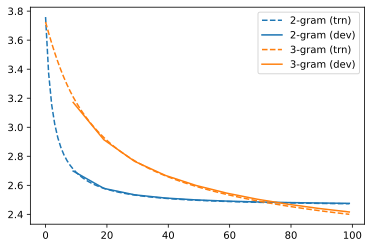

In [28]:
plt.plot([k for k, v in hist_bigram['loss_trn']], [v for k, v in hist_bigram['loss_trn']], color=f'C0', linestyle='dashed', label="2-gram (trn)")
plt.plot([k for k, v in hist_bigram['loss_dev']], [v for k, v in hist_bigram['loss_dev']], color=f'C0', label="2-gram (dev)")

plt.plot([k for k, v in hist_trigram['loss_trn']], [v for k, v in hist_trigram['loss_trn']], color=f'C1', linestyle='dashed', label="3-gram (trn)")
plt.plot([k for k, v in hist_trigram['loss_dev']], [v for k, v in hist_trigram['loss_dev']], color=f'C1', label="3-gram (dev)")

plt.legend();

The trigram model seems to generalize better than the bigram model.

### Exercise 3 

Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?


**Solution.** Adding regularization on the loss.

test_loss=2.4063
test_loss=2.4062
test_loss=2.4060
test_loss=2.4036
test_loss=2.4079
test_loss=2.7302
test_loss=3.1823


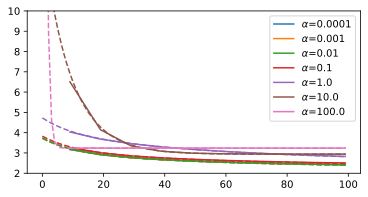

In [29]:
from functools import partial

def regularized_nll_loss(model, xs, ys, alpha):
    probs = model(xs)
    nll = -probs[torch.arange(len(ys)), ys].log().mean()
    reg = alpha * model.W.square().mean()
    return nll + reg


plt.figure(figsize=(6, 3))
for i, alpha in enumerate([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]):
    model = TrigramModel()
    history = train_model(
        model, xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst, 
        loss_fn=partial(regularized_nll_loss, alpha=alpha),
        verbose=False
    )
    plt.plot([k for k, v in history['loss_trn']], [v for k, v in history['loss_trn']], color=f'C{i}', linestyle='dashed')
    plt.plot([k for k, v in history['loss_dev']], [v for k, v in history['loss_dev']], color=f'C{i}', label=r'$\alpha$='+f"{alpha}")
    print(f"test_loss={nll_loss(model, xs_tst, ys_tst):.4f}") # Not include reg loss.
    
plt.ylim(2, 10)
plt.legend();

As discussed above, the stronger the regularization, the more uniform the output distributions become. Hence, we tend to get worse performing models. Indeed, we see that the loss converges to worse values as we increase $\alpha$ which controls the strength of regularization. It approaches the NLL for a model that assigns the same probability to all ${n}$ characters $-\log \frac{1}{{n}} = \log {n}.$

In [30]:
import math
math.log(27.0)

3.295836866004329

### Exercise 4 & 5

We saw that our 1-hot vectors merely select a row of `W`, so producing these vectors explicitly feels wasteful. Can you delete our use of `F.one_hot` in favor of simply indexing into rows of `W`? Look up and use `F.cross_entropy` instead. You should achieve the same result. Can you think of why we'd prefer to use `F.cross_entropy` instead?

**Solution.** Simply index the rows of the weights matrix using the input tensor of indices:

In [31]:
class TrigramModelEfficient:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27*27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        logits = self.W[xs]
        return logits
        
    def zero_grad(self):
        self.W.grad = None

    def optim_step(self, lr):
        self.W.data -= lr * self.W.grad

From [the docs](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), applying `F.cross_entropy` to the logits is equivalent to NLL with softmax probabilities. Here we define a helper function since we have a different API for the loss:

[010/100]    loss=3.2084    dev_loss=3.1711
[020/100]    loss=2.9292    dev_loss=2.9141
[030/100]    loss=2.7695    dev_loss=2.7653
[040/100]    loss=2.6664    dev_loss=2.6685
[050/100]    loss=2.5932    dev_loss=2.5993
[060/100]    loss=2.5374    dev_loss=2.5464
[070/100]    loss=2.4930    dev_loss=2.5042
[080/100]    loss=2.4566    dev_loss=2.4697
[090/100]    loss=2.4262    dev_loss=2.4409
[100/100]    loss=2.4003    dev_loss=2.4164
test_loss=2.4063


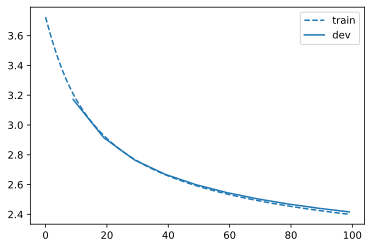

In [32]:
def cross_entropy_loss(model, xs, ys):
    return F.cross_entropy(model(xs), ys)

history = train_model(
    TrigramModelEfficient(), xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst, 
    loss_fn=cross_entropy_loss,
    verbose=True
)

plt.plot([k for k, v in history['loss_trn']], [v for k, v in history['loss_trn']], color=f'C0', linestyle='dashed', label="train")
plt.plot([k for k, v in history['loss_dev']], [v for k, v in history['loss_dev']], color=f'C0', label="dev");
plt.legend();

Note that we get the same results as in the previous implementation of the trigram model ([Exercise 2](https://particle1331.github.io/inefficient-networks/notebooks/language-modeling/01-bigrams.html#exercise-2)). But this is super fast: 10x faster than the previous implementation. 
Also, using cross-entropy loss on logits avoids potential overflow with exponentials. Notice that the right-hand term is more numerically stable by forcing the largest exponential to be 1 (even if the other terms underflow):

$$
\begin{aligned}
\log \left( \frac {\exp(s_i)}{\sum_{j} \exp(s_j)} \right) 
&= s_i - \log \left( {\sum_{j} \exp(s_j)} \right) \\
&= (s_i - s_{j^*}) - \log \left( {\sum_{j} \exp(s_j - s_{j^*})} \right)
\end{aligned}$$

where $s_{j^*} = \max_j s_j.$ This expression can be used as the implemented value for cross-entropy.